# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch14/ch14_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-08-19 07:11:43--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-08-19 07:11:43 (38.1 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'torch': '1.8.0',
    'torchvision': '0.9.0'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] scipy 1.10.1
[OK] matplotlib 3.7.1
[OK] torch 2.0.1+cu118
[OK] torchvision 0.15.2+cu118


# 14장 - 심층 합성곱 신경망으로 이미지 분류 (파트 2/2)

**목차**

- 합성곱 신경망을 사용하여 웃는 얼굴 분류
  - CelebA 데이터셋 로드
  - 이미지 변환과 데이터 증식
  - CNN 웃는 얼굴 분류기 훈련
- 요약

In [3]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## 합성곱 신경망을 사용하여 웃는 얼굴 분류

### CelebA 데이터셋 로드

아래 코드 셀에서 `download=True`를 설정해 볼 수 있지만, CelebA 데이터셋의 일일 다운로드 제한으로 인해 오류가 발생할 수 있습니다. 이런 경우 다음을 시도해 보시기 바랍니다:

- CelebA 공식 웹사이트에서 파일을 수동으로 다운로드할 수 있습니다. (https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
- 또는 다음 다운로드 링크를 사용하세요. https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing (추천).

이 링크를 사용하면 `celeba.zip` 파일이 다운로드됩니다.

1. 코드를 실행 중인 현재 디렉터리에서 압축을 풀어야 합니다.
2. 또한, **`celeba` 폴더 안에 있는 `img_align_celeba.zip` 파일의 압축도 반드시 풀어야 합니다.
3. 또한 다운로드해서 celeba 폴더에  압축을 푼 후 아래 코드 셀에 표시된 것처럼 `download=True` 대신 `download=False`으로 설정하여 실행해야 합니다.

이 방식에 문제가 있는 경우 https://github.com/rickiepark/ml-with-pytorch 에서 새 이슈를 열거나 토론을 시작하여 알려주세요.

In [4]:
import torchvision

image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=True)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=True)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=True)

print('훈련 세트:', len(celeba_train_dataset))
print('검증 세트:', len(celeba_valid_dataset))
print('테스트 세트:', len(celeba_test_dataset))

1443490838it [00:23, 61852947.49it/s]
26721026it [00:00, 63850478.40it/s]
3424458it [00:00, 194341779.36it/s]
6082035it [00:00, 187601789.46it/s]
12156055it [00:00, 144988824.62it/s]
2836386it [00:00, 213680559.41it/s]


Files already downloaded and verified
Files already downloaded and verified
훈련 세트: 162770
검증 세트: 19867
테스트 세트: 19962


### 이미지 변환과 데이터 증식

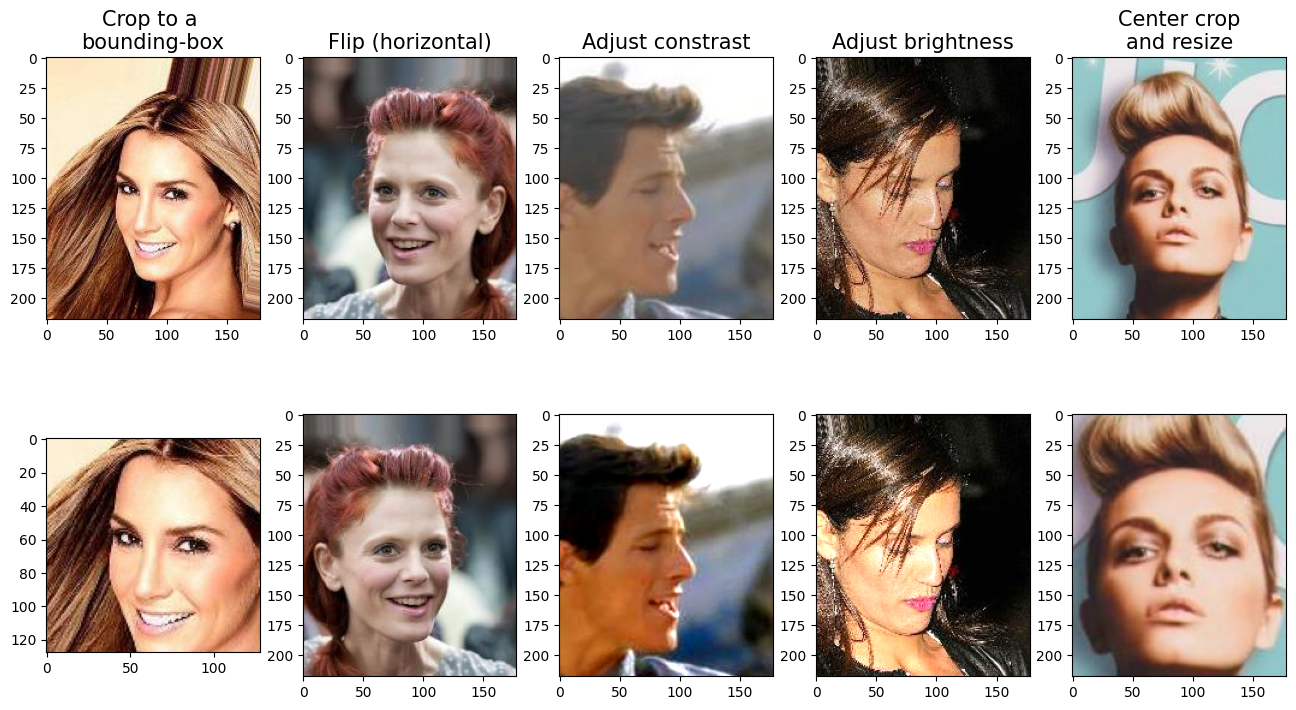

In [5]:
from torchvision import transforms

## 다섯 개 샘플

fig = plt.figure(figsize=(16, 8.5))

## 1열: 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## 2열: (수평으로) 뒤집기
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## 3열: 대비 조정
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열: 명도 조정
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## 5열: 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)

# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

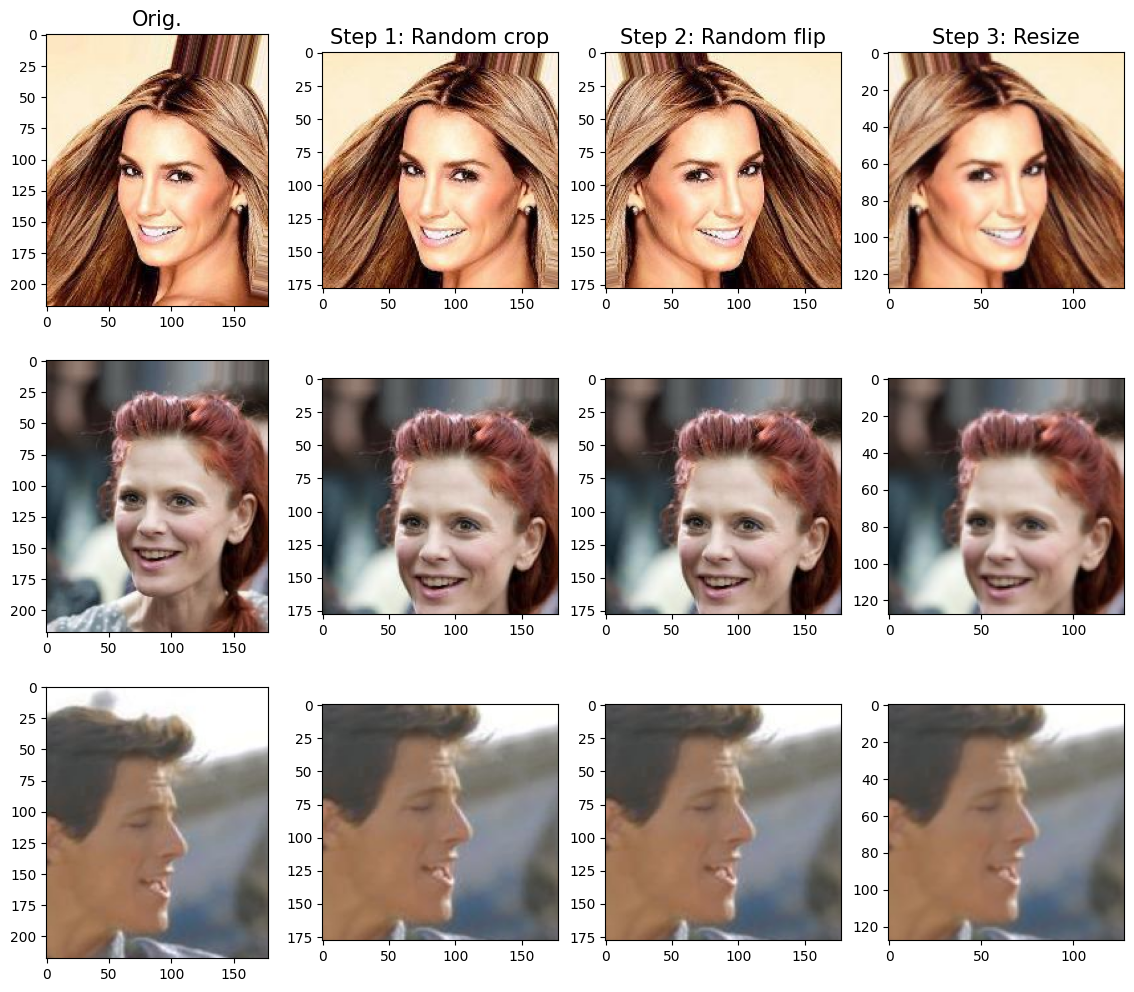

In [6]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

    if i == 2:
        break

# plt.savefig('figures/14_15.png', dpi=300)
plt.show()

In [7]:
get_smile = lambda attr: attr[31]

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

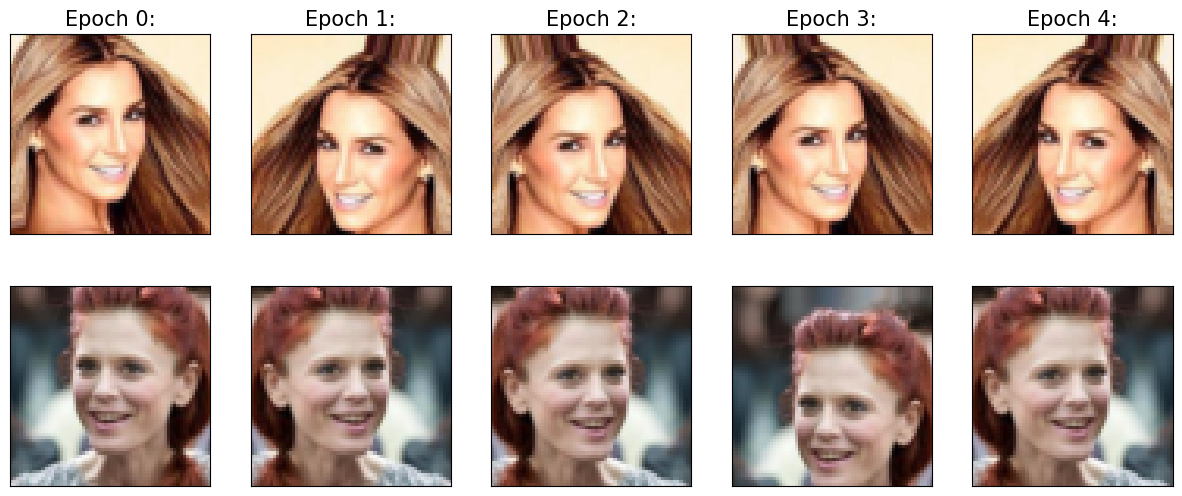

In [8]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='train',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))


#plt.savefig('figures/14_16.png', dpi=300)
plt.show()

In [9]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='valid',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='test',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform,
                                                   target_transform=get_smile)

from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

print('훈련 세트:', len(celeba_train_dataset))
print('검증 세트:', len(celeba_valid_dataset))

훈련 세트: 16000
검증 세트: 1000


In [10]:
batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

### CNN 웃는 얼굴 분류기 훈련

In [11]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [12]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [13]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [14]:
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

In [15]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [16]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'에포크 {epoch+1} 정확도: {accuracy_hist_train[epoch]:.4f} 검증 정확도: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

에포크 1 정확도: 0.5149 검증 정확도: 0.5140
에포크 2 정확도: 0.5183 검증 정확도: 0.5140
에포크 3 정확도: 0.5281 검증 정확도: 0.5680
에포크 4 정확도: 0.5649 검증 정확도: 0.5950
에포크 5 정확도: 0.5972 검증 정확도: 0.6130
에포크 6 정확도: 0.6177 검증 정확도: 0.5970
에포크 7 정확도: 0.6371 검증 정확도: 0.5920
에포크 8 정확도: 0.6489 검증 정확도: 0.5740
에포크 9 정확도: 0.6636 검증 정확도: 0.6350
에포크 10 정확도: 0.6733 검증 정확도: 0.6490
에포크 11 정확도: 0.6905 검증 정확도: 0.6710
에포크 12 정확도: 0.7088 검증 정확도: 0.6770
에포크 13 정확도: 0.7358 검증 정확도: 0.7420
에포크 14 정확도: 0.7723 검증 정확도: 0.7760
에포크 15 정확도: 0.7939 검증 정확도: 0.8100
에포크 16 정확도: 0.8110 검증 정확도: 0.8370
에포크 17 정확도: 0.8224 검증 정확도: 0.8410
에포크 18 정확도: 0.8306 검증 정확도: 0.8650
에포크 19 정확도: 0.8343 검증 정확도: 0.8450
에포크 20 정확도: 0.8449 검증 정확도: 0.8590
에포크 21 정확도: 0.8480 검증 정확도: 0.8670
에포크 22 정확도: 0.8520 검증 정확도: 0.8790
에포크 23 정확도: 0.8554 검증 정확도: 0.8650
에포크 24 정확도: 0.8612 검증 정확도: 0.8710
에포크 25 정확도: 0.8628 검증 정확도: 0.8810
에포크 26 정확도: 0.8659 검증 정확도: 0.8850
에포크 27 정확도: 0.8679 검증 정확도: 0.8800
에포크 28 정확도: 0.8696 검증 정확도: 0.8830
에포크 29 정확도: 0.8723 검증 정확도: 0.8840
에포크 30 정확도: 0.8731 검증 정

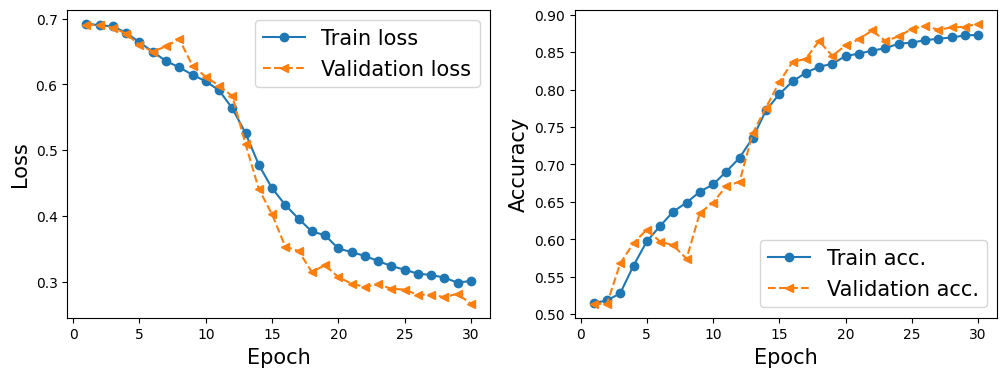

In [19]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [20]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'테스트 정확도: {accuracy_test:.4f}')

테스트 정확도: 0.9032


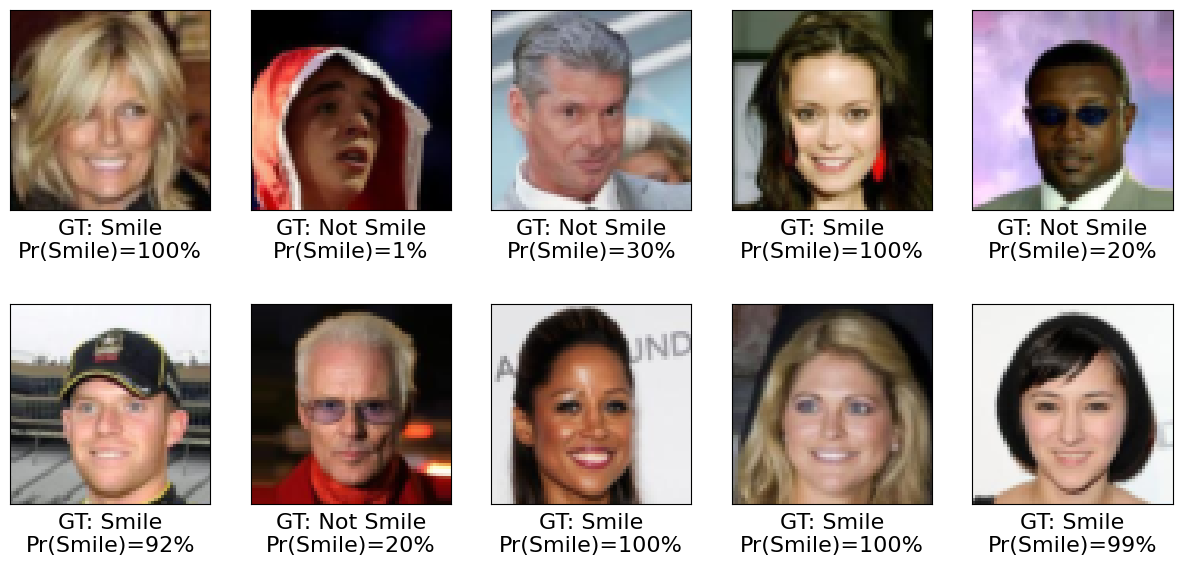

In [21]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

In [22]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'
torch.save(model, path)

## 요약